# Imports and preinstallation

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from skimage.measure import compare_ssim as ssim
import skimage
import tarfile
import sklearn.utils
import sklearn as skl
import IPython.display as ipd
import requests
import sys
import zipfile
import pandas as pd
import ast
import librosa
import librosa.display
from PIL import Image
import numpy as np
from sklearn import manifold, datasets, decomposition, ensemble, discriminant_analysis, random_projection
from sklearn.model_selection import train_test_split
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
from time import time
import IPython
import xgboost as xgb
import scipy as sc
from keras import models, layers, optimizers, utils, losses, callbacks
import tensorflow
import csv
import google.colab as gc
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix

## Help functions

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
example_track_id = 55718
music_dir = 'fma_small'

In [0]:
np.random.seed(42)
tensorflow.set_random_seed(42)

In [5]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

#IPython.get_ipython().events.unregister('pre_run_cell', configure_plotly_browser_state)
init_notebook_mode(connected=True)

In [0]:
def download(url, filename):
    with open(filename, 'wb') as f:
        response = requests.get(url, stream=True)
        total = response.headers.get('content-length')

        if total is None:
            f.write(response.content)
        else:
            sys.stdout.write('Downloading {} of size {} from {}\n'.format(
                filename, total, url))
            downloaded = 0
            total = int(total)
            for data in response.iter_content(chunk_size=max(int(total/1000), 1024*1024)):
                downloaded += len(data)
                f.write(data)
                done = int(50*downloaded/total)
                sys.stdout.write('\r[{}{}]'.format('█' * done, '.' * (50-done)))
                sys.stdout.flush()
    sys.stdout.write('\nDone\n')

In [0]:
def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                'category', categories=SUBSETS, ordered=True)

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks

In [0]:
def plot_history(history, title=''):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    epochs = range(1, len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## Install libs

In [0]:
!pip install clint

  Stored in directory: /root/.cache/pip/wheels/4f/e9/45/223565e5b1a4b09e12c6de6f8ba7c2c0e9127dec17cf830f83
  Stored in directory: /root/.cache/pip/wheels/58/54/ea/d995d18af68c057eb76b87b02c92bc66ac34d360ef141780f4
Successfully built clint args


In [0]:
!pip install plotly --upgrade

Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (3.6.1)


In [0]:
!pip install utils

Fix for 'title' has invalid value inside 'layout'

# Explore FMA

### Downloading various sizes of MP3-encoded audio data

In [0]:
download('https://os.unil.cloud.switch.ch/fma/fma_metadata.zip', 'fma_metadata.zip')
with zipfile.ZipFile('fma_metadata.zip', 'r') as zip_ref:
    zip_ref.extractall('')

[██████████████████████████████████████████████████]
Done


In [0]:
name = 'fma_small'
download('https://os.unil.cloud.switch.ch/fma/fma_small.zip', name + '.zip')

[██████████████████████████████████████████████████]
Done


In [0]:
with zipfile.ZipFile(name + '.zip', 'r') as zip_ref:
    zip_ref.extractall('')

### Reading data

In [10]:
tracks = load('fma_metadata/tracks.csv')
genres = load('fma_metadata/genres.csv')
#features = load('fma_metadata/features.csv')
#echonest = load('fma_metadata/echonest.csv')

tracks.shape, genres.shape#, features.shape, echonest.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning:

specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead



((106574, 52), (163, 4))

### Audio

In [0]:
def get_audio_path(track_id, audio_dir='fma_small'):
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

In [0]:
filename = get_audio_path(example_track_id)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=12000, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 12, 22
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

File: fma_small/055/055718.mp3
Duration: 30.00s, 360033 samples


(-1, 1)

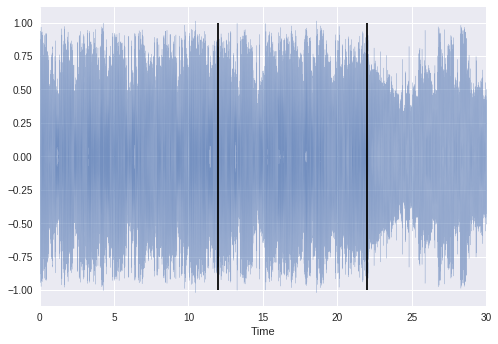

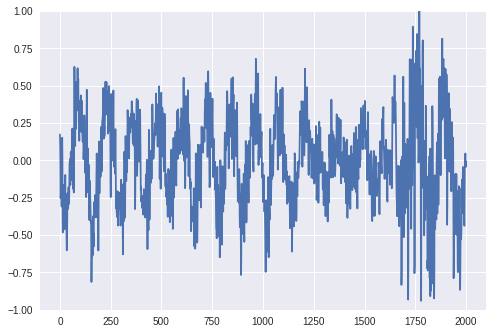

In [0]:
librosa.display.waveplot(x, sr, alpha=0.5)
plt.vlines([start, end], -1, 1)

start = len(x) // 2
plt.figure()
plt.plot(x[start:start+2000])
plt.ylim((-1, 1))

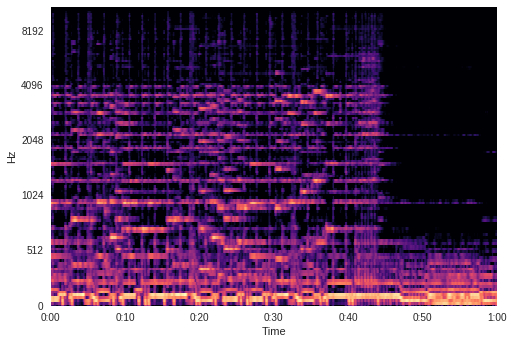

In [0]:
mel = librosa.feature.melspectrogram(x, sr=sr, n_fft=4096, hop_length=256)
log_mel = librosa.amplitude_to_db(mel)
librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel')

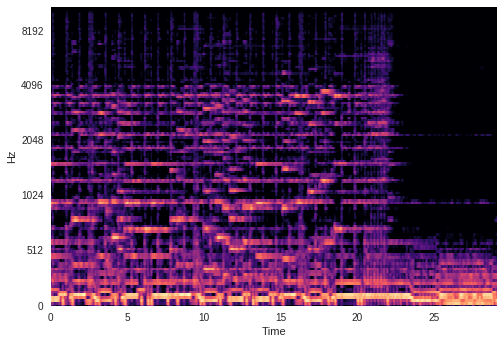

In [0]:
mel = librosa.feature.melspectrogram(x, sr=sr, n_fft=4096, hop_length=256)
log_mel = librosa.amplitude_to_db(abs(mel))[:,:1366]
librosa.display.specshow(log_mel, sr=sr, hop_length=256, x_axis='time', y_axis='mel')

In [0]:
np.array(log_mel).shape

(128, 1366)

In [0]:
np.array(log_mel).max()

83.71940694438806

In [0]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
X_train = features.loc[small & train, 'mfcc']
X_test = features.loc[small & test, 'mfcc']

In [0]:
X_train.shape, y_train.shape

((6400, 140), (6400,))

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



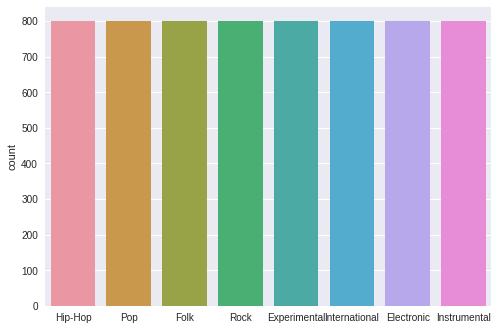

In [0]:
sns.countplot(np.array(y_train))

# Processing audio

## Converting mp3

In [0]:
if not os.path.exists('mels'):
  os.makedirs('mels')

In [0]:
def extract_melspec(audio_fpath, min_frames=1366):
  y, sr = librosa.load(audio_fpath, sr=12000, mono=True)
  mel = librosa.feature.melspectrogram(y, sr=sr)
  log_mel = np.array(librosa.amplitude_to_db(abs(mel)))
  if log_mel.shape[1] < min_frames:
    raise ValueError('Failed getting mels')
  return log_mel[:,:min_frames]

In [0]:
!rm -rf mels

In [0]:
ok_cnt = 0
fail_cnt = 0
#count = 4
#ci = 0
for subdir, _, files in os.walk(music_dir):
  for file in files:
    if file.lower().endswith('.mp3'):
      fpath = os.path.join(subdir, file)
      fname, _ = os.path.splitext(file)
      try:
        data = extract_melspec(fpath)
        data.tofile(f'mels/{fname}.txt')
      except Exception as e:
        print('Fail', file, 'message', e, 'with path:', fpath)
        fail_cnt += 1
        continue
      ok_cnt += 1
      if ok_cnt % 100 == 0:
        print(f'OK {ok_cnt}')
      #ci += 1
      #if ci >= count:
        #break
    else:
      continue
  #if ci >= count:
    #break

print('Generated {}/{}'.format(ok_cnt, ok_cnt + fail_cnt))

OK 100
OK 200
OK 300
Fail 099134.mp3 message  with path: fma_small/099/099134.mp3
OK 400
OK 500
OK 600
OK 700
OK 800
OK 900
OK 1000
OK 1100
OK 1200
OK 1300
OK 1400
OK 1500
OK 1600
OK 1700
OK 1800
OK 1900
OK 2000
OK 2100
OK 2200
OK 2300
OK 2400
OK 2500
OK 2600
OK 2700
OK 2800
OK 2900
OK 3000
OK 3100
OK 3200
OK 3300
OK 3400
OK 3500
OK 3600
Fail 133297.mp3 message  with path: fma_small/133/133297.mp3
OK 3700
Fail 098567.mp3 message Failed getting mels with path: fma_small/098/098567.mp3
Fail 098569.mp3 message Failed getting mels with path: fma_small/098/098569.mp3
Fail 098565.mp3 message Failed getting mels with path: fma_small/098/098565.mp3
OK 3800
OK 3900
OK 4000
OK 4100
OK 4200
OK 4300
OK 4400
OK 4500
OK 4600
OK 4700
OK 4800
OK 4900
OK 5000
OK 5100
OK 5200
OK 5300
OK 5400
OK 5500
OK 5600
OK 5700
OK 5800
OK 5900
OK 6000
OK 6100
OK 6200
OK 6300
OK 6400
OK 6500
OK 6600
OK 6700
OK 6800
Fail 108925.mp3 message  with path: fma_small/108/108925.mp3
OK 6900
OK 7000
OK 7100
OK 7200
OK 7300
OK

In [0]:
zf = zipfile.ZipFile('mels.zip', 'w')
for dirname, subdirs, files in os.walk('mels'):
    for filename in files:
        zf.write(os.path.join(dirname, filename))
zf.close()

In [0]:
from google.colab import files
files.download('mels.zip') 

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 51692, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [0]:
def convert_bytes(num):
    """
    this function will convert bytes to MB.... GB... etc
    """
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if num < 1024.0:
            return "%3.1f %s" % (num, x)
        num /= 1024.0


def file_size(file_path):
    """
    this function will return the file size
    """
    if os.path.isfile(file_path):
        file_info = os.stat(file_path)
        return convert_bytes(file_info.st_size)
file_size('mels.zip'), file_size('/content/drive/My Drive/mels.zip'), file_size('/content/drive/My Drive/Colab Notebooks/mels.zip')

In [0]:
from shutil import copy
copy('mels.zip', '/content/drive/My Drive/Colab Notebooks/mels.zip')

In [0]:
with zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/mels.zip','r') as zip_ref:
    zip_ref.extractall()

## Converting mp3

In [0]:
if not os.path.exists('mels2'):
  os.makedirs('mels2')

In [0]:
def extract_melspec(audio_fpath, min_frames=1366):
  y, sr = librosa.load(audio_fpath, sr=12000, mono=True)
  mel = librosa.feature.melspectrogram(y, sr=sr)
  log_mel = np.array(librosa.amplitude_to_db(mel))
  if log_mel.shape[1] < min_frames:
    raise ValueError('Failed getting mels')
  return log_mel[:,:min_frames]

In [0]:
!rm -rf mels

In [0]:
ok_cnt = 0
fail_cnt = 0
#count = 4
#ci = 0
for subdir, _, files in os.walk(music_dir):
  for file in files:
    if file.lower().endswith('.mp3'):
      fpath = os.path.join(subdir, file)
      fname, _ = os.path.splitext(file)
      try:
        data = extract_melspec(fpath)
        data.tofile(f'mels/{fname}.txt')
      except Exception as e:
        print('Fail', file, 'message', e, 'with path:', fpath)
        fail_cnt += 1
        continue
      ok_cnt += 1
      if ok_cnt % 100 == 0:
        print(f'OK {ok_cnt}')
      #ci += 1
      #if ci >= count:
        #break
    else:
      continue
  #if ci >= count:
    #break

print('Generated {}/{}'.format(ok_cnt, ok_cnt + fail_cnt))

OK 100
OK 200
OK 300
Fail 099134.mp3 message  with path: fma_small/099/099134.mp3
OK 400
OK 500
OK 600
OK 700
OK 800
OK 900
OK 1000
OK 1100
OK 1200
OK 1300
OK 1400
OK 1500
OK 1600
OK 1700
OK 1800
OK 1900
OK 2000
OK 2100
OK 2200
OK 2300
OK 2400
OK 2500
OK 2600
OK 2700
OK 2800
OK 2900
OK 3000
OK 3100
OK 3200
OK 3300
OK 3400
OK 3500
OK 3600
Fail 133297.mp3 message  with path: fma_small/133/133297.mp3
OK 3700
Fail 098567.mp3 message Failed getting mels with path: fma_small/098/098567.mp3
Fail 098569.mp3 message Failed getting mels with path: fma_small/098/098569.mp3
Fail 098565.mp3 message Failed getting mels with path: fma_small/098/098565.mp3
OK 3800
OK 3900
OK 4000
OK 4100
OK 4200
OK 4300
OK 4400
OK 4500
OK 4600
OK 4700
OK 4800
OK 4900
OK 5000
OK 5100
OK 5200
OK 5300
OK 5400
OK 5500
OK 5600
OK 5700
OK 5800
OK 5900
OK 6000
OK 6100
OK 6200
OK 6300
OK 6400
OK 6500
OK 6600
OK 6700
OK 6800
Fail 108925.mp3 message  with path: fma_small/108/108925.mp3
OK 6900
OK 7000
OK 7100
OK 7200
OK 7300
OK

In [0]:
zf = zipfile.ZipFile('mels.zip', 'w')
for dirname, subdirs, files in os.walk('mels'):
    for filename in files:
        zf.write(os.path.join(dirname, filename))
zf.close()

In [0]:
from google.colab import files
files.download('mels.zip') 

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 51692, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [0]:
def convert_bytes(num):
    """
    this function will convert bytes to MB.... GB... etc
    """
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if num < 1024.0:
            return "%3.1f %s" % (num, x)
        num /= 1024.0


def file_size(file_path):
    """
    this function will return the file size
    """
    if os.path.isfile(file_path):
        file_info = os.stat(file_path)
        return convert_bytes(file_info.st_size)
file_size('mels.zip'), file_size('/content/drive/My Drive/mels.zip'), file_size('/content/drive/My Drive/Colab Notebooks/mels.zip')

In [0]:
from shutil import copy
copy('mels.zip', '/content/drive/My Drive/Colab Notebooks/mels.zip')

In [0]:
with zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/mels.zip','r') as zip_ref:
    zip_ref.extractall()

## Discover mels

In [0]:
small_track_ids = []
track_ids = tracks['track'].index.values
for subdir, _, files in os.walk('mels'):
  for file in files:
    if file.lower().endswith('.txt'):
      fpath = os.path.join(subdir, file)
      fname, _ = os.path.splitext(file) # (filename, extension)
      small_track_ids.append(int(fname))

In [0]:
def display_mels(fpath):
  data = np.fromfile(fpath).reshape(128, 1366)
  librosa.display.specshow(data, sr=12000, hop_length=512, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')

In [0]:
def format_fname(fname, min_length=6):
    while len(fname) < min_length:
        fname = '0' + fname
    return fname

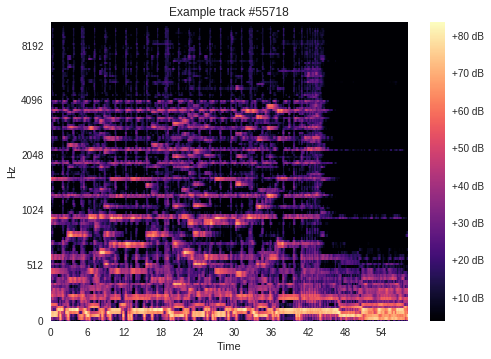

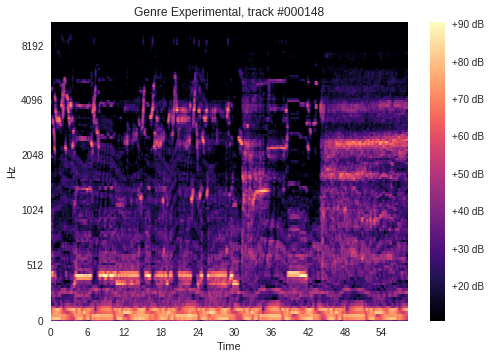

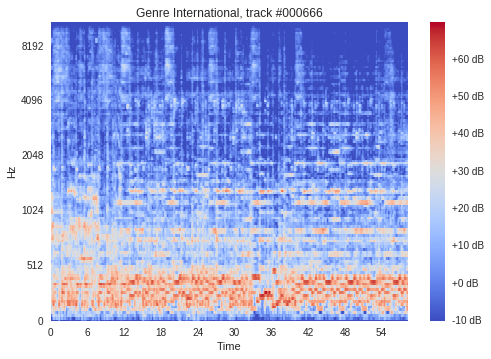

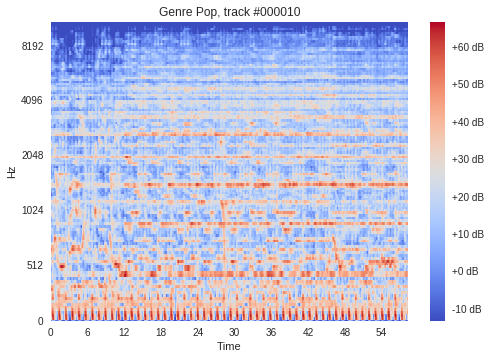

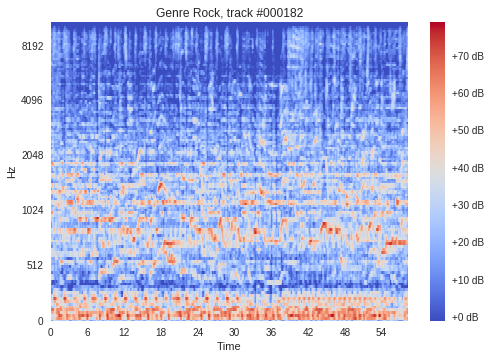

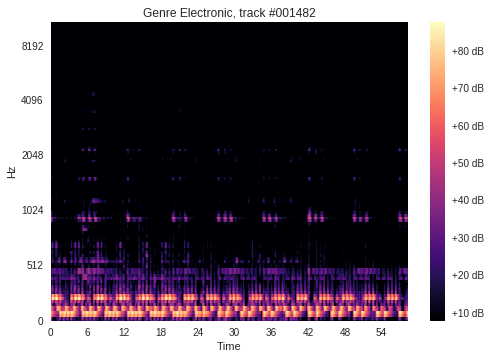

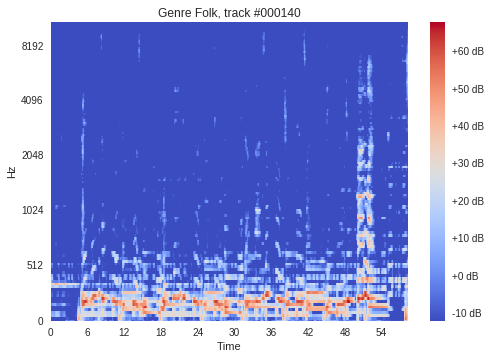

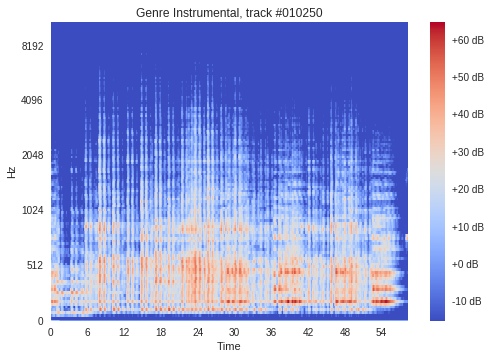

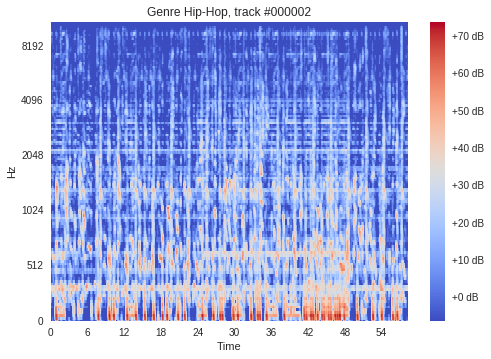

In [171]:
plt.figure()
plt.title(f'Example track #{example_track_id}')
display_mels(f'mels/{format_fname(str(example_track_id))}.txt')

tracks_data = tracks['track']
tracks_data = tracks_data[tracks_data.index.isin(small_track_ids)]
small_genres = []

for genre in genres.loc[genres['top_level'].unique()]['title']:
  data = tracks_data[tracks_data['genre_top'] == genre].head(1)
  if len(data) == 0:
    continue
  track_id = format_fname(str(data.index.item()))
  small_genres.append(genre)
  
  plt.figure()
  plt.title(f'Genre {genre}, track #{track_id}')
  display_mels(f'mels/{track_id}.txt')

# Neural networks using custom

In [0]:
X_names = []
genre_list = []
for name in small_track_ids:
  X_names.append(format_fname(str(name)))
  genre = tracks_data[tracks_data.index.isin([name])]['genre_top'].values[0]
  genre_list.append(genre)

X_names = np.array(X_names)
genre_list = np.array(genre_list)

In [16]:
X_names.shape, genre_list.shape

((7994,), (7994,))

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



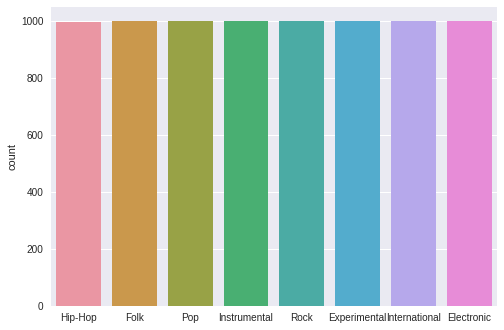

In [17]:
sns.countplot(np.array(genre_list))

In [0]:
encoder = skl.preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)
y = utils.to_categorical(y)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_names, y, test_size=0.33, random_state=42)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5355,), (2639,), (5355, 8), (2639, 8))

Conv > Normalization > Activation > Dropout > Pooling

In [0]:
def extract_melspec(audio_fpath):
  y, sr = librosa.load(audio_fpath, sr=12000, mono=True)
  mel = librosa.feature.melspectrogram(y, sr=sr)
  log_mel = np.array(librosa.amplitude_to_db(mel))
  return log_mel[:,:1366]

In [0]:
def get_audio_path(track_id):
  tid_str = '{:06d}'.format(track_id)
  return os.path.join('fma_small', tid_str[:3], tid_str + '.mp3')

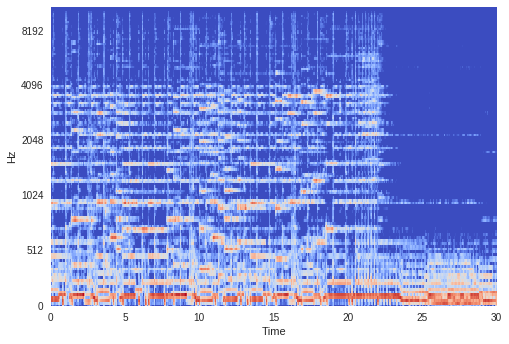

In [87]:
librosa.display.specshow(extract_melspec(get_audio_path(example_track_id)), sr=12000, hop_length=512, x_axis='time', y_axis='mel')

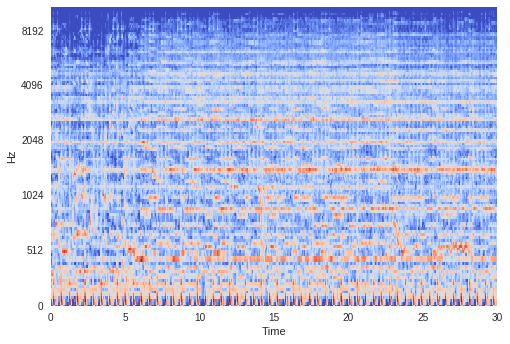

In [172]:
librosa.display.specshow(extract_melspec(get_audio_path(10)), sr=12000, hop_length=512, x_axis='time', y_axis='mel')

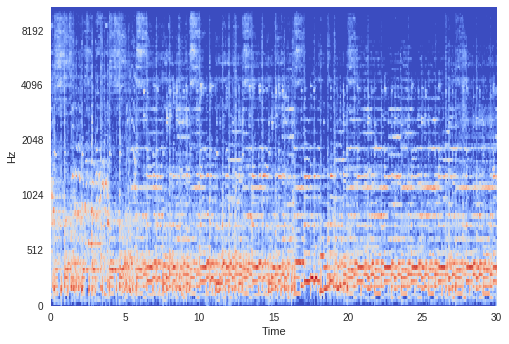

In [173]:
librosa.display.specshow(extract_melspec(get_audio_path(666)), sr=12000, hop_length=512, x_axis='time', y_axis='mel')

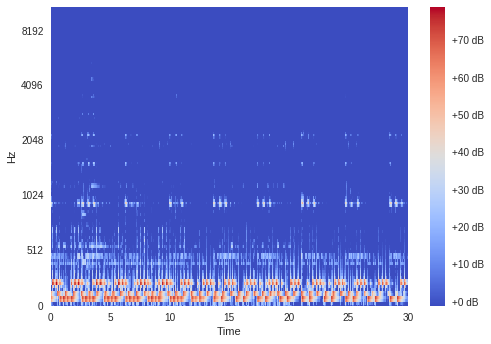

In [175]:
librosa.display.specshow(extract_melspec(get_audio_path(1482)), sr=12000, hop_length=512, x_axis='time', y_axis='mel')

## Conv1d

In [0]:
def generate_train_data(batch_size):
  i = 0
  while True:
    batch_X = []
    batch_y = []
    for b in range(batch_size):
      if i == len(X_train):
        i = 0
        np.random.shuffle(X_train)
      sample_name = X_train[i]
      i += 1
      
      fpath = f'mels/{format_fname(str(sample_name))}.txt'
      X = np.fromfile(fpath).reshape(128, 1366)[:,400:900].T
      genre = tracks_data[tracks_data.index.isin([int(sample_name)])]['genre_top'].values[0]
      y = utils.to_categorical(encoder.transform([genre])[0], num_classes=len(encoder.classes_))
      batch_X.append(X)
      batch_y.append(y)
    yield np.array(batch_X), np.array(batch_y)

In [0]:
def generate_test_data(batch_size):
  i = 0
  while True:
    batch_X = []
    batch_y = []
    for b in range(batch_size):
      if i == len(X_test):
        i = 0
        np.random.shuffle(X_test)
      sample_name = X_test[i]
      i += 1
      
      fpath = f'mels/{format_fname(str(sample_name))}.txt'
      X = np.fromfile(fpath).reshape(128, 1366)[:,400:900].T
      genre = tracks_data[tracks_data.index.isin([int(sample_name)])]['genre_top'].values[0]
      y = utils.to_categorical(encoder.transform([genre])[0], num_classes=len(encoder.classes_))
      batch_X.append(X)
      batch_y.append(y)
    yield np.array(batch_X), np.array(batch_y)

In [0]:
def get_model(x_shape, y_shape):
  input_layer = layers.Input(shape=x_shape, name='input')

  c1 = layers.Conv1D(128, 4, padding='same')(input_layer)
  bn1 = layers.BatchNormalization()(c1)
  a1 = layers.Activation('relu')(bn1)
  d1 = layers.Dropout(0.2)(a1)
  mp1 = layers.MaxPooling1D(pool_size=4, padding='same')(d1)

  c2 = layers.Conv1D(256, 2, padding='same')(mp1)
  bn2 = layers.BatchNormalization()(c2)
  a2 = layers.Activation('relu')(bn2)
  d2 = layers.Dropout(0.2)(a2)
  mp2 = layers.MaxPooling1D(pool_size=4, padding='same')(d2)
  
  c3 = layers.Conv1D(512, 2, padding='same')(mp2)
  bn3 = layers.BatchNormalization()(c3)
  a3 = layers.Activation('relu')(bn3)
  d3 = layers.Dropout(0.2)(a3)
  mp3 = layers.MaxPooling1D(pool_size=2, padding='same')(d3)
  
  #c4 = layers.Conv1D(512, 4, padding='same')(mp3)
  #bn4 = layers.BatchNormalization()(c4)
  #a4 = layers.Activation('relu')(bn4)
  #d4 = layers.Dropout(0.3)(a4)
  
  gmp = layers.GlobalMaxPooling1D()(d3)
  gap = layers.GlobalAveragePooling1D()(d3)
  cc = layers.concatenate([gmp, gap])
  
  c5 = layers.Dense(256)(cc)
  bn5 = layers.BatchNormalization()(c5)
  a5 = layers.Activation('relu')(bn5)
  d5 = layers.Dropout(0.2)(a5)
  
  c6 = layers.Dense(64)(d5)
  bn6 = layers.BatchNormalization()(c6)
  a6 = layers.Activation('relu')(bn6)
  d6 = layers.Dropout(0.2)(a6)
  
  #c7 = layers.Dense(64)(d6)
  #bn7 = layers.BatchNormalization()(c7)
  #a7 = layers.Activation('relu')(bn7)
  #d7 = layers.Dropout(0.3)(a7)
  
  output = layers.Dense(y_shape, activation='softmax', name='output')(d6)

  model = models.Model(inputs=input_layer, outputs=output)
  model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])
  
  return model


In [0]:
model = get_model(x_shape=(500, 128), y_shape=y_train.shape[1])

In [217]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 500, 128)     0                                            
__________________________________________________________________________________________________
conv1d_67 (Conv1D)              (None, 500, 128)     65664       input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_147 (BatchN (None, 500, 128)     512         conv1d_67[0][0]                  
__________________________________________________________________________________________________
activation_134 (Activation)     (None, 500, 128)     0           batch_normalization_147[0][0]    
__________________________________________________________________________________________________
dropout_14

In [0]:
model_filename = 'model.pkl'
cbs = [
    callbacks.EarlyStopping(monitor='val_loss',
                  patience=10,
                  verbose=1,
                  mode='auto')
]

In [219]:
batch_size = 256
history = model.fit_generator(
    generate_train_data(batch_size),
    validation_data=generate_test_data(batch_size),
    epochs=1000, callbacks=cbs,
    steps_per_epoch=np.ceil(len(X_train) / batch_size),
    validation_steps=np.ceil(len(X_test) / batch_size))

Epoch 1/1000
21/21 [==============================] - 74s 4s/step - loss: 2.2382 - acc: 0.2115 - val_loss: 1.9951 - val_acc: 0.2596
Epoch 2/1000
21/21 [==============================] - 76s 4s/step - loss: 1.9607 - acc: 0.3069 - val_loss: 2.0017 - val_acc: 0.2543
Epoch 3/1000
21/21 [==============================] - 76s 4s/step - loss: 1.8478 - acc: 0.3545 - val_loss: 1.9685 - val_acc: 0.2759
Epoch 4/1000
21/21 [==============================] - 77s 4s/step - loss: 1.7667 - acc: 0.3795 - val_loss: 1.9341 - val_acc: 0.2905
Epoch 5/1000
21/21 [==============================] - 76s 4s/step - loss: 1.7015 - acc: 0.4012 - val_loss: 2.0090 - val_acc: 0.2667
Epoch 6/1000
21/21 [==============================] - 76s 4s/step - loss: 1.6544 - acc: 0.4172 - val_loss: 1.9814 - val_acc: 0.2859
Epoch 7/1000
 1/21 [>.............................] - ETA: 58s - loss: 1.6190 - acc: 0.4297

KeyboardInterrupt: ignored

In [0]:
plot_history(history)

In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Accuracy: {:.2%}'.format(test_acc))

In [0]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_test_classes = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

In [0]:
my_model = KerasRegressor(build_fn=get_model,
  x_shape=X_train.shape, y_shape=y_train.shape,
  epochs=20, batch_size=512, validation_data=(X_test, y_test))    
hist = my_model.fit(X_train, y_train)
perm = PermutationImportance(my_model, random_state=42).fit(X_train, y_train)

In [0]:
eli5.show_weights(perm, feature_names=data.columns[:-1].tolist(), top=None)

In [0]:
plot_history(hist)

In [0]:
y_pred = my_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_test_classes = np.argmax(y_test, axis=1) 
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

## Conv2d

In [0]:
def generate_train_data(batch_size):
  i = 0
  while True:
    batch_X = []
    batch_y = []
    for b in range(batch_size):
      if i == len(X_train):
        i = 0
        np.random.shuffle(X_train)
      sample_name = X_train[i]
      i += 1
      
      fpath = f'mels/{format_fname(str(sample_name))}.txt'
      X = np.fromfile(fpath).reshape(1, 128, 1366)[:,:,400:900].T
      genre = tracks_data[tracks_data.index.isin([int(sample_name)])]['genre_top'].values[0]
      y = utils.to_categorical(encoder.transform([genre])[0], num_classes=len(encoder.classes_))
      batch_X.append(X)
      batch_y.append(y)
    yield np.array(batch_X), np.array(batch_y)

In [0]:
def generate_test_data(batch_size):
  i = 0
  while True:
    batch_X = []
    batch_y = []
    for b in range(batch_size):
      if i == len(X_test):
        i = 0
        np.random.shuffle(X_test)
      sample_name = X_test[i]
      i += 1
      
      fpath = f'mels/{format_fname(str(sample_name))}.txt'
      X = np.fromfile(fpath).reshape(1, 128, 1366)[:,:,400:900].T
      genre = tracks_data[tracks_data.index.isin([int(sample_name)])]['genre_top'].values[0]
      y = utils.to_categorical(encoder.transform([genre])[0], num_classes=len(encoder.classes_))
      batch_X.append(X)
      batch_y.append(y)
    yield np.array(batch_X), np.array(batch_y)

In [0]:
def get_model(x_shape, y_shape):
  model = models.Sequential()
  model.add(layers.Conv2D(8, (4, 4), padding='valid', input_shape=x_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling2D(pool_size=(4, 4)))

  for layer in range(2):
      model.add(layers.Conv2D(32, (2, 2)))
      model.add(layers.BatchNormalization())
      model.add(layers.ELU(alpha=1.0))  
      model.add(layers.MaxPooling2D(pool_size=(2, 2)))
      model.add(layers.Dropout(0.3))
  
  model.add(layers.Conv2D(32, (2, 2)))
  model.add(layers.BatchNormalization())
  model.add(layers.ELU(alpha=1.0))  
  model.add(layers.MaxPooling2D(pool_size=(4, 4)))
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(128))
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(y_shape))
  model.add(layers.Activation("softmax"))
  
  model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy'])
  return model

In [0]:
model = get_model(x_shape=(500, 128, 1), y_shape=y_train.shape[1])

In [229]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 497, 125, 8)       136       
_________________________________________________________________
batch_normalization_156 (Bat (None, 497, 125, 8)       32        
_________________________________________________________________
activation_142 (Activation)  (None, 497, 125, 8)       0         
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 124, 31, 8)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 123, 30, 32)       1056      
_________________________________________________________________
batch_normalization_157 (Bat (None, 123, 30, 32)       128       
_________________________________________________________________
elu_30 (ELU)                 (None, 123, 30, 32)       0         
__________

In [0]:
model_filename = 'model.pkl'
cbs = [
    callbacks.EarlyStopping(monitor='val_loss',
                  patience=10,
                  verbose=1,
                  mode='auto')
]

In [231]:
batch_size = 256
history = model.fit_generator(
    generate_train_data(batch_size),
    validation_data=generate_test_data(batch_size),
    epochs=1000, callbacks=cbs,
    steps_per_epoch=np.ceil(len(X_train) / batch_size),
    validation_steps=np.ceil(len(X_test) / batch_size))

Epoch 1/1000
21/21 [==============================] - 70s 3s/step - loss: 2.9434 - acc: 0.1473 - val_loss: 2.0182 - val_acc: 0.2205
Epoch 2/1000
21/21 [==============================] - 74s 4s/step - loss: 2.0745 - acc: 0.1724 - val_loss: 2.0002 - val_acc: 0.2120
Epoch 3/1000
21/21 [==============================] - 76s 4s/step - loss: 2.0473 - acc: 0.1756 - val_loss: 1.9846 - val_acc: 0.2223
Epoch 4/1000
21/21 [==============================] - 75s 4s/step - loss: 2.0193 - acc: 0.1942 - val_loss: 1.9453 - val_acc: 0.2322
Epoch 5/1000
21/21 [==============================] - 75s 4s/step - loss: 1.9921 - acc: 0.2167 - val_loss: 1.9663 - val_acc: 0.2319
Epoch 6/1000
 3/21 [===>..........................] - ETA: 52s - loss: 1.9896 - acc: 0.2122

KeyboardInterrupt: ignored

In [0]:
plot_history(history)

In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Accuracy: {:.2%}'.format(test_acc))

In [0]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_test_classes = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

In [0]:
my_model = KerasRegressor(build_fn=get_model,
  x_shape=X_train.shape, y_shape=y_train.shape,
  epochs=20, batch_size=512, validation_data=(X_test, y_test))    
hist = my_model.fit(X_train, y_train)
perm = PermutationImportance(my_model, random_state=42).fit(X_train, y_train)

In [0]:
eli5.show_weights(perm, feature_names=data.columns[:-1].tolist(), top=None)

In [0]:
plot_history(hist)

In [0]:
y_pred = my_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_test_classes = np.argmax(y_test, axis=1) 
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

## test

In [0]:
def get_audio_path(track_id):
  tid_str = '{:06d}'.format(track_id)
  return os.path.join('fma_small', tid_str[:3], tid_str + '.mp3')

In [0]:
def extract_melspec(audio_fpath):
  y, sr = librosa.load(audio_fpath, sr=12000, mono=True)
  mel = librosa.feature.melspectrogram(y, sr=sr)
  log_mel = np.array(librosa.amplitude_to_db(mel))
  return log_mel[:,:1366]

In [0]:
def generate_train_data(batch_size):
  i = 0
  while True:
    batch_X = []
    batch_y = []
    for b in range(batch_size):
      if i == len(X_train):
        i = 0
        np.random.shuffle(X_train)
      sample_name = int(X_train[i])
      i += 1
      
      fpath = get_audio_path(sample_name)
      X = extract_melspec(fpath).T
      genre = tracks_data[tracks_data.index.isin([sample_name])]['genre_top'].values[0]
      y = utils.to_categorical(encoder.transform([genre])[0], num_classes=len(encoder.classes_))
      batch_X.append(X)
      batch_y.append(y)
    yield np.array(batch_X), np.array(batch_y)

In [0]:
def generate_test_data(batch_size):
  i = 0
  while True:
    batch_X = []
    batch_y = []
    for b in range(batch_size):
      if i == len(X_test):
        i = 0
        np.random.shuffle(X_test)
      sample_name = X_test[i]
      i += 1
      
      fpath = get_audio_path(sample_name)
      X = extract_melspec(fpath).T
      genre = tracks_data[tracks_data.index.isin([sample_name])]['genre_top'].values[0]
      y = utils.to_categorical(encoder.transform([genre])[0], num_classes=len(encoder.classes_))
      batch_X.append(X)
      batch_y.append(y)
    yield np.array(batch_X), np.array(batch_y)

In [0]:
def get_model(x_shape, y_shape):
  input_layer = layers.Input(shape=x_shape, name='input')

  c1 = layers.Conv1D(128, 4, padding='same')(input_layer)
  bn1 = layers.BatchNormalization()(c1)
  a1 = layers.Activation('relu')(bn1)
  d1 = layers.Dropout(0.2)(a1)
  mp1 = layers.MaxPooling1D(pool_size=4, padding='same')(d1)

  c2 = layers.Conv1D(256, 2, padding='same')(mp1)
  bn2 = layers.BatchNormalization()(c2)
  a2 = layers.Activation('relu')(bn2)
  d2 = layers.Dropout(0.2)(a2)
  mp2 = layers.MaxPooling1D(pool_size=4, padding='same')(d2)
  
  c3 = layers.Conv1D(512, 2, padding='same')(mp2)
  bn3 = layers.BatchNormalization()(c3)
  a3 = layers.Activation('relu')(bn3)
  d3 = layers.Dropout(0.2)(a3)
  mp3 = layers.MaxPooling1D(pool_size=2, padding='same')(d3)
  
  #c4 = layers.Conv1D(512, 4, padding='same')(mp3)
  #bn4 = layers.BatchNormalization()(c4)
  #a4 = layers.Activation('relu')(bn4)
  #d4 = layers.Dropout(0.3)(a4)
  
  gmp = layers.GlobalMaxPooling1D()(d3)
  gap = layers.GlobalAveragePooling1D()(d3)
  cc = layers.concatenate([gmp, gap])
  
  c5 = layers.Dense(256)(cc)
  bn5 = layers.BatchNormalization()(c5)
  a5 = layers.Activation('relu')(bn5)
  d5 = layers.Dropout(0.2)(a5)
  
  c6 = layers.Dense(64)(d5)
  bn6 = layers.BatchNormalization()(c6)
  a6 = layers.Activation('relu')(bn6)
  d6 = layers.Dropout(0.2)(a6)
  
  #c7 = layers.Dense(64)(d6)
  #bn7 = layers.BatchNormalization()(c7)
  #a7 = layers.Activation('relu')(bn7)
  #d7 = layers.Dropout(0.3)(a7)
  
  output = layers.Dense(y_shape, activation='softmax', name='output')(d6)

  model = models.Model(inputs=input_layer, outputs=output)
  model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])
  
  return model


In [0]:
model = get_model(x_shape=(1366, 128), y_shape=y_train.shape[1])

In [254]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1366, 128)    0                                            
__________________________________________________________________________________________________
conv1d_77 (Conv1D)              (None, 1366, 128)    65664       input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_170 (BatchN (None, 1366, 128)    512         conv1d_77[0][0]                  
__________________________________________________________________________________________________
activation_155 (Activation)     (None, 1366, 128)    0           batch_normalization_170[0][0]    
__________________________________________________________________________________________________
dropout_16

In [0]:
model_filename = 'model.pkl'
cbs = [
    callbacks.EarlyStopping(monitor='val_loss',
                  patience=10,
                  verbose=1,
                  mode='auto')
]

In [255]:
batch_size = 256
history = model.fit_generator(
    generate_train_data(batch_size),
    validation_data=generate_test_data(batch_size),
    epochs=1000, callbacks=cbs,
    steps_per_epoch=np.ceil(len(X_train) / batch_size),
    validation_steps=np.ceil(len(X_test) / batch_size))

Epoch 1/1000


KeyboardInterrupt: ignored

In [0]:
plot_history(history)

In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Accuracy: {:.2%}'.format(test_acc))

In [0]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_test_classes = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

In [0]:
my_model = KerasRegressor(build_fn=get_model,
  x_shape=X_train.shape, y_shape=y_train.shape,
  epochs=20, batch_size=512, validation_data=(X_test, y_test))    
hist = my_model.fit(X_train, y_train)
perm = PermutationImportance(my_model, random_state=42).fit(X_train, y_train)

In [0]:
eli5.show_weights(perm, feature_names=data.columns[:-1].tolist(), top=None)

In [0]:
plot_history(hist)

In [0]:
y_pred = my_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_test_classes = np.argmax(y_test, axis=1) 
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

## Todo

In [0]:
def get_model(x_shape, y_shape):
  model = keras.models.Sequential()

  model.add(layers.Conv1D(256, 4, input_shape=x_shape[1:], padding='same', name='C1'))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.MaxPooling1D(pool_size=4, padding='same', name='S2'))

  model.add(layers.Conv1D(256, 4, padding='same', name='C3'))
  model.add(ayers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(ayers.Dropout(0.3))
  model.add(layers.MaxPooling1D(pool_size=2, padding='same', name='S4'))
  
  model.add(layers.Conv1D(512, 4, padding='same', name='C5'))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.3))
  
  gmp = layers.GlobalMaxPooling1D(name='S6')
  gap = layers.GlobalAveragePooling1D(name='S7')
  models.add(layers.concatenate(gmp, gap))
  
  model.add(layers.Dense(1024, padding='same', name='F8'))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.3))
  
  model.add(layers.Dense(256, padding='same', name='F8'))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.3))
  
  model.add(layers.Dense(64, padding='same', name='F8'))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.3))
  
  model.add(keras.layers.Dense(y_shape[1], activation='softmax', name='Output'))

  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
  
  return model


In [0]:
model = get_model(X_train.shape, y_train.shape)
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512)

In [0]:
plot_history(history)

In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Accuracy: {:.2%}'.format(test_acc))

In [0]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_test_classes = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

In [0]:
my_model = KerasRegressor(build_fn=get_model,
  x_shape=X_train.shape, y_shape=y_train.shape,
  epochs=20, batch_size=512, validation_data=(X_test, y_test))    
hist = my_model.fit(X_train, y_train)
perm = PermutationImportance(my_model, random_state=42).fit(X_train, y_train)

In [0]:
eli5.show_weights(perm, feature_names=data.columns[:-1].tolist(), top=None)

In [0]:
plot_history(hist)

In [0]:
y_pred = my_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_test_classes = np.argmax(y_test, axis=1) 
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)